In [1]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [2]:
llm = ChatOpenAI(model="gpt-4o")

In [ ]:
# Schema for structured output
from pydantic import BaseModel, Field
from langchain_community.tools import TavilySearchResults


class SearchQuries(BaseModel):
    search_query: list = Field(
        None, description="List of Queries that are optimized for web search."
    )
    justification: list = Field(
        None, description="Why each query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuries)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")


# Define a tool
tavily_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([tavily_tool])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke(
    "nvidia 주가 하락의 원인이 된 대상 이름이 뭐야?그리고 그 대상에 대한 정보 알려줘"
)

# Get the tool call
msg.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'NVIDIA stock price drop reason entity name'},
  'id': 'call_IhiLMtYIOVmr1VergSJ3Y2c6',
  'type': 'tool_call'}]

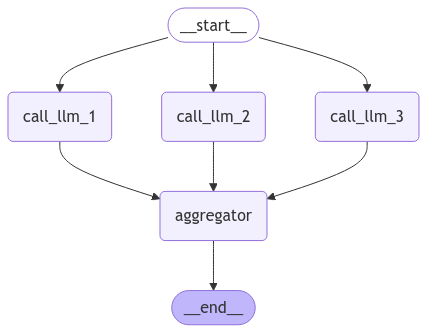

Here's a story, joke, and poem about cats!

STORY:
Title: The Secret Society of Whiskers

In the quiet town of Willowbrook, nestled between rolling hills and whispering forests, there existed a secret society known only to the feline inhabitants. They called themselves "The Whisker Council," a gathering of the wisest and most adventurous cats from every corner of the town.

Every full moon, when the silver light bathed the cobblestone streets in a mystical glow, the cats would congregate at the old, abandoned library on Elm Street. This library, cloaked in vines and the memories of a bygone era, was their sanctuary—a place where human footsteps had long since faded, leaving only the echo of rustling pages and the soft purr of contented cats.

The leader of The Whisker Council was an elderly, dignified Siamese named Solomon. His fur was a tapestry of cream and chocolate, and his azure eyes spoke of ancient secrets and wisdom gleaned from many moonlit nights. Despite his age, Solomon mov

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


class SearchQury(BaseModel):
    search_query: str = Field(
        None, description="Query that is optimized for web search."
    )
    justification: str = Field(
        None, description="Why query is relevant to the user's request."
    )


class Reference(BaseModel):
    """Model for a reference"""

    title: str = Field(description="The title of the reference.")
    url: str = Field(description="The url of the reference.")


# Graph state
class State(TypedDict):
    search_queries: list[SearchQury]

    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

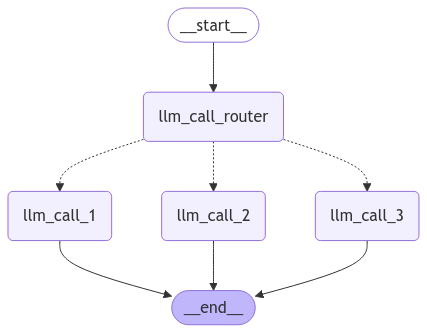

Why was the cat sitting on the computer?  
Because it wanted to keep an eye on the mouse!


In [ ]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

In [ ]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

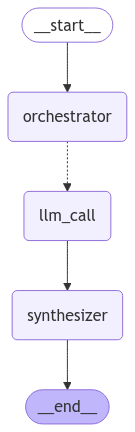

# Introduction to LLM Scaling Laws

Scaling laws in machine learning, particularly in the context of large language models (LLMs), refer to the empirical relationships that describe how changes in model size, data quantity, and computational resources impact performance. These laws offer insights into how models can be systematically improved by scaling up these dimensions. The introduction of scaling laws has been pivotal in guiding the development of LLMs, such as GPT, BERT, and their successors, which have demonstrated remarkable capabilities in natural language understanding and generation.

The significance of scaling laws lies in their ability to provide a framework for predicting the performance of LLMs as they grow larger. By understanding these laws, researchers and practitioners can make informed decisions about the trade-offs between model size, training data, and computational power. This is particularly crucial in a field where the resources required for training state-of-the-art models are substantial.

One of the key aspects of scaling laws is their ability to highlight the diminishing returns of model performance as the size increases beyond certain thresholds. This understanding helps in setting realistic expectations and optimizing resource allocation. For example, scaling laws have shown that while increasing the number of parameters in a model generally leads to better performance, the rate of improvement decreases with each additional parameter. This insight is crucial for balancing the cost and benefit of training larger models.

Furthermore, scaling laws are instrumental in identifying the bottlenecks and limitations of current models and guiding future research directions. They provide a scientific basis for exploring new architectures and data-efficient training methods that could potentially offer better scalability.

In summary, scaling laws are a foundational concept in the development and understanding of LLMs. They not only elucidate the relationships between model size, data, and computation but also serve as a strategic tool for optimizing the design and training of future models. As LLMs continue to evolve, scaling laws will remain an essential component of the research toolkit, enabling continuous advancements in the field of machine learning.

---

## Historical Background and Development

The exploration of scaling laws in machine learning, particularly in the context of large language models (LLMs), has been a pivotal area of research that has significantly influenced the development and optimization of these models. The study of scaling laws aims to understand how the performance of machine learning models changes as a function of their size, data, and computational resources. This section delves into the historical trajectory of scaling laws, highlighting critical milestones and studies that have shaped the current landscape.

### Early Foundations

The concept of scaling laws in machine learning can be traced back to the late 20th century when researchers began observing that increasing the size of neural networks often led to better performance on a variety of tasks. However, the systematic study of these phenomena only began in earnest as computational resources and data availability grew.

### Emergence of Scaling Laws

A significant milestone in understanding scaling laws came from the work of Hinton et al. in the 2000s, who demonstrated that deeper networks could lead to better feature representations and performance. This period saw the development of techniques like dropout and ReLU activations, which made training larger networks more feasible.

### The Deep Learning Revolution

The early 2010s marked a revolution in deep learning, driven by breakthroughs in training techniques and hardware accelerations. AlexNet's success in the ImageNet competition in 2012 illustrated the power of large-scale networks, setting a precedent for subsequent research. This era highlighted a fundamental scaling law: model performance tends to improve with increased model size and dataset availability, provided the architecture and training methods are appropriately managed.

### Formalizing Scaling Laws

The formalization of scaling laws in language models began with large-scale empirical investigations. Notably, the 2019 paper by Kaplan et al. titled "Scaling Laws for Neural Language Models" provided a quantitative framework for understanding how model performance scales with the number of parameters, dataset size, and computational resources. This study found that performance follows predictable power-law relationships, offering insights into optimal resource allocation for training large models.

### Breakthroughs in LLMs

The development of transformer architectures, introduced by Vaswani et al. in 2017, was another crucial milestone. Transformers facilitated the scaling of models to unprecedented sizes, leading to the creation of the first large language models like BERT and GPT. The success of these models underscored the importance of scaling as a key factor in achieving state-of-the-art results across various natural language processing tasks.

### Recent Advances and Understanding

Recent years have seen further advancements in scaling laws, with studies exploring the limits of model size and data efficiency. Research has shown that while increasing model size generally leads to performance gains, there are diminishing returns beyond a certain point, and the benefits of scaling must be balanced with considerations of efficiency and cost.

### Future Directions

The ongoing exploration of scaling laws continues to shape the future of machine learning. Current research is focused on understanding the qualitative behaviors that arise from scaling, such as emergent capabilities in LLMs like GPT-3. As models continue to grow, researchers are also investigating more efficient architectures and training methods to harness the full potential of scaling laws without prohibitive resource demands.

In conclusion, the study of scaling laws has been instrumental in guiding the development of large language models, providing a framework for understanding how to best allocate resources to enhance model performance. As the field evolves, continued research into these laws will be crucial for pushing the boundaries of what is possible in machine learning.

---

### Mathematical Foundations of Scaling Laws

Scaling laws, a central concept in various scientific disciplines, describe how certain properties of a system change with size. They provide a mathematical framework for understanding how different variables interact across scales. In machine learning, particularly in the development of large language models (LLMs), scaling laws offer insights into how increases in model size, dataset size, and computational resources affect performance.

#### Power Laws and Dimensional Analysis

At the heart of scaling laws is the concept of power laws, which are mathematical relationships where one quantity varies as a power of another. The general form of a power law is:

\[ y = kx^a \]

where \( y \) and \( x \) are variables, \( k \) is a constant, and \( a \) is the scaling exponent. Power laws are frequently observed in natural phenomena and are crucial in dimensional analysis—a method that involves determining how different physical quantities interact and scale with each other.

In machine learning, power laws help model the relationship between the size of a model (e.g., the number of parameters) and its performance, such as accuracy or prediction error. This relationship often follows a power law, indicating that beyond a certain point, increasing the model size yields diminishing returns.

#### Information Theory and Entropy

Scaling laws in LLMs are also informed by principles from information theory, particularly the concept of entropy. Entropy measures the uncertainty or unpredictability of a system. As LLMs scale, the amount of information they can capture and the diversity of patterns they can recognize also increase. This is often quantified using concepts like cross-entropy loss, which measures the difference between true probability distributions and those predicted by the model.

#### Optimization and Learning Curves

Optimization theory provides another mathematical underpinning for scaling laws. As models grow in size, the complexity of the optimization landscape increases. However, empirical studies have shown that larger models often find better minima in terms of generalization ability, following a predictable relationship with the amount of data and computational power.

Learning curves, which plot the model's error or accuracy against the amount of training data, often exhibit scaling behavior. Theoretically, these curves can be modeled using power laws, allowing predictions about how much data or computation is needed to achieve a desired level of performance.

#### Application to Language Models

In the context of LLMs, scaling laws have been applied to understand and predict how increases in model parameters, data, and computational resources impact language understanding and generation capabilities. For instance, studies have shown that:

1. **Parameter Scaling**: Doubling the number of parameters in a model tends to improve performance, but the improvement rate decreases as the model becomes very large.
   
2. **Data Scaling**: Increasing the size of the training dataset often leads to significant improvements in model performance, particularly when combined with larger models.

3. **Compute Scaling**: More computational resources allow for more extensive training, enabling models to explore more complex solutions in the parameter space.

By applying scaling laws, researchers can make informed decisions on resource allocation and predict the potential benefits of scaling up models. This has led to the development of state-of-the-art LLMs, such as GPT-3 and beyond, which leverage these mathematical insights to achieve unprecedented levels of natural language understanding and generation.

In summary, the mathematical principles of power laws, information theory, and optimization theory provide a robust framework for understanding scaling laws in LLMs. These principles help predict how changes in model size, data, and computation influence performance, guiding the development of increasingly powerful language models.

---

## Empirical Evidence and Case Studies

The exploration of scaling laws within large language models (LLMs) is an active area of research, driven by the increasing capability of these models as they grow in size and complexity. This section reviews empirical studies and experiments that have tested scaling laws, providing insights into how these laws apply to LLMs. Furthermore, we present case studies from prominent AI research organizations that offer practical evidence and analysis of these phenomena.

### Empirical Studies on Scaling Laws

Recent empirical studies have demonstrated that scaling up language models in terms of parameters, data, and compute power generally leads to improved performance across a wide array of natural language processing tasks. Kaplan et al. (2020) provided one of the foundational studies by establishing that the performance of LLMs follows predictable power-law relationships with respect to model size, dataset size, and computational budget. Their work illustrated that, as models grow, the returns on performance improvements diminish, but they do not plateau, which suggests that continued scaling could yield additional gains.

Further investigations by Henighan et al. (2020) explored the implications of these scaling laws on transfer learning and zero-shot capabilities. They found that larger models tend to generalize better to new tasks, even without task-specific finetuning, which reinforces the potential of LLMs to handle diverse applications as they scale.

### Case Studies from Leading AI Research Organizations

#### OpenAI's GPT-3

One of the most notable case studies is OpenAI's GPT-3, which exemplifies the application of scaling laws. With 175 billion parameters, GPT-3 is a testament to the predictive power of scaling laws. OpenAI's research found that GPT-3 exhibits remarkable few-shot learning capabilities, which align with the predictions made by earlier scaling law studies. The model demonstrates proficiency in tasks such as translation, question-answering, and language generation without explicit training on these tasks, showcasing the advantages and potential of scaling.

#### DeepMind's Gopher

DeepMind's Gopher project provides another critical case study. Gopher, a model with 280 billion parameters, was developed to evaluate the scaling properties further. DeepMind's findings corroborate previous research, emphasizing that larger models can achieve state-of-the-art results across various benchmarks. Their experiments also highlighted that while larger models do better in terms of raw performance, they also require significant innovations in architecture and optimization techniques to manage the computational and efficiency challenges posed by such scale.

### Analysis of Findings

The empirical evidence and case studies from leading research organizations consistently show that scaling laws hold significant predictive power for the development of LLMs. As models expand, they not only perform better on traditional benchmarks but also exhibit emergent properties such as improved generalization and zero-shot learning abilities. However, the studies also underline the increasing costs associated with scaling, including higher computational demands and environmental impacts.

The analysis suggests that future research must focus on both the efficient scaling of models and the development of novel architectures that can maximize the benefits of scaling without proportionally increasing resource consumption. Additionally, understanding the limits of current scaling laws and identifying potential breakthroughs in model design or training methodologies will be crucial for the sustainable advancement of LLMs.

In conclusion, the empirical evidence and case studies reviewed demonstrate the profound impact of scaling laws on the capabilities of large language models, underscoring the importance of these principles in guiding future AI research and development efforts.

---

### Implications for Model Training and Performance

Scaling laws have emerged as a cornerstone in the field of machine learning, offering critical insights into the relationship between the size of a model and its performance. These laws have profound practical implications for training large language models, influencing decisions regarding model architecture, resource allocation, and performance optimization.

#### Model Architecture

Scaling laws suggest that larger models tend to perform better, provided they are trained on sufficiently large datasets. This has prompted researchers and practitioners to explore expansive model architectures, often involving billions of parameters. As a consequence, the design of model architectures must balance complexity with scalability. Techniques such as layer normalization, residual connections, and attention mechanisms have been optimized to support the efficient scaling of models. Furthermore, understanding these laws helps in making informed decisions about model width and depth, ensuring that each additional parameter contributes meaningfully to performance improvements.

#### Resource Allocation

The implications of scaling laws extend significantly to resource allocation. Training large models demands considerable computational power and memory resources. Organizations must allocate substantial GPU/TPU resources to handle the increased computational load. Scaling laws also inform decisions about data pipeline optimization, ensuring that data throughput can match the model's training demands. Additionally, these laws encourage investment in distributed training infrastructure, enabling parallel processing that reduces training time and cost.

#### Performance Optimization

Performance optimization is directly influenced by scaling laws, guiding strategies to maximize the efficiency of large models. Regularization techniques, such as dropout and weight decay, become more critical as models scale, helping to prevent overfitting despite the increase in capacity. Hyperparameter tuning, including learning rate schedules and batch size adjustments, is also tailored based on insights from scaling laws to ensure convergence and stability during training.

Moreover, scaling laws inform practitioners about diminishing returns in model performance relative to size, allowing for more strategic planning. Understanding when additional parameters yield negligible performance gains can help in making cost-effective decisions, balancing the trade-offs between model size and performance benefits.

In essence, scaling laws serve as a blueprint for optimizing the development and deployment of large language models, ensuring that every aspect—from architecture to resource allocation—is aligned with the overarching goal of achieving superior performance in a practical and efficient manner.

---

### Challenges and Limitations

The application of scaling laws to large language models (LLMs) presents several challenges and limitations that can impact their development and deployment. These challenges arise from various factors, including computational cost, data availability, and diminishing returns, all of which are crucial for understanding the practical and theoretical constraints within which these models operate.

#### Computational Cost

One of the primary challenges in leveraging scaling laws for LLMs is the significant computational cost involved. As models scale, the computational resources required to train them increase exponentially. This includes the need for advanced hardware, such as GPUs or TPUs, and extensive energy consumption. The financial burden of such resources can limit accessibility, often restricting the ability to develop and train large models to well-funded organizations and institutions. Additionally, the environmental impact due to increased energy demands poses an ethical concern, pushing the need for more efficient training algorithms and sustainable practices.

#### Data Availability

Another critical limitation is the availability of high-quality and diverse datasets necessary for training LLMs. Scaling laws suggest that as the size of a model increases, the amount of data needed to effectively train it also grows. However, acquiring and curating vast datasets is a non-trivial task. Issues such as data privacy, copyright restrictions, and the prevalence of biases within datasets complicate the data acquisition process. Furthermore, the saturation of available data can lead to challenges in maintaining model performance improvements as the model size increases, which can hinder further scalability.

#### Diminishing Returns

As LLMs scale, the improvements in performance may start to experience diminishing returns. Initially, increasing the size of a model and the amount of training data tends to yield significant improvements in performance. However, beyond a certain point, the incremental benefits of further scaling can decrease, making it less cost-effective. This phenomenon raises questions about the optimal model size and the balance between model complexity and practical utility. Achieving substantial gains in specific tasks might require disproportionately more resources compared to the performance benefits gained, necessitating a strategic approach to scaling.

#### Conclusion

In summary, while scaling laws provide a framework for understanding the growth potential of LLMs, they also highlight significant challenges and limitations. Addressing these challenges requires innovative approaches to reduce computational costs, enhance data availability, and manage the diminishing returns associated with scaling. By acknowledging and tackling these issues, researchers and developers can more effectively navigate the complexities of scaling LLMs, leading to more practical and sustainable use of these powerful models.

---

### Future Directions and Research Opportunities

The field of Large Language Model (LLM) scaling laws is rapidly evolving, offering a plethora of opportunities for future research. This section explores emerging trends, novel approaches, and the potential impact these advancements may have on artificial intelligence development.

#### Emerging Trends

1. **Scaling Laws Beyond Language**: While current scaling laws primarily focus on language models, there is a growing interest in extending these laws to multimodal models that integrate text, images, audio, and possibly other data types. Understanding how scaling affects multimodal learning will be crucial for developing more generalized AI systems.

2. **Efficient Scaling**: As models grow larger, the computational and environmental costs become significant. Research is increasingly focusing on developing more efficient scaling methods that maintain or improve performance while reducing resource consumption. Techniques such as sparse models, knowledge distillation, and neural architecture search are gaining traction.

3. **Fine-Tuning and Transferability**: Investigating how scaling laws influence the fine-tuning of models for specific tasks and their ability to transfer knowledge across domains is a promising area of research. This could lead to more robust models that require less data and fewer computational resources to adapt to new tasks.

#### Novel Approaches

1. **Meta-Learning and Self-Supervised Learning**: Integrating meta-learning principles with scaling laws could result in models that are better at learning how to learn, potentially leading to more autonomous systems that can adapt to new situations with minimal supervision.

2. **Dynamic Scaling**: Developing models that can dynamically adjust their parameters and architecture based on the task or data at hand is a novel approach that could provide significant flexibility and efficiency. This direction emphasizes adaptability in model design, allowing for real-time optimization.

3. **Exploration of Non-Traditional Architectures**: While transformer-based architectures have dominated the landscape, exploring scaling laws in non-traditional architectures, such as neural ordinary differential equations or spiking neural networks, could yield insights into alternative pathways for AI development.

#### Potential Impact on AI Development

The continued exploration of LLM scaling laws is poised to have a profound impact on AI development:

- **Enhanced Capabilities**: By understanding and leveraging scaling laws, researchers can build models with enhanced capabilities, such as improved reasoning, creativity, and problem-solving skills, which are crucial for complex real-world applications.

- **Democratization of AI**: Efficient scaling methods can make powerful AI tools more accessible, enabling smaller organizations and independent researchers to contribute to AI advancements without prohibitive costs.

- **Ethical and Social Implications**: As models become more powerful, it is crucial to address the ethical and societal implications of their deployment. Future research must consider how scaling impacts issues such as bias, privacy, and accountability, ensuring that AI development aligns with human values.

In conclusion, the future of LLM scaling laws is rich with possibilities, offering numerous research opportunities that could redefine the boundaries of AI. By embracing these challenges and exploring innovative approaches, the AI community can drive the development of more capable, efficient, and ethical AI systems.

---

## Conclusion

In this report, we have explored the intricate dynamics of scaling laws and their pivotal role in enhancing the performance of large language models (LLMs). The key points discussed underscore the transformative impact of scaling laws, elucidating how they serve as a guiding framework for developing more sophisticated and capable language models.

Firstly, we examined the fundamental principles of scaling laws, highlighting their empirical basis and the consistent patterns observed in the performance improvements of LLMs as they increase in size. These scaling laws provide valuable insights into the relationship between model size, data volume, and computational resources, offering a blueprint for optimizing model development.

Secondly, the report delved into the practical implications of scaling laws, demonstrating their utility in predicting and planning the growth trajectory of LLMs. By understanding these relationships, researchers and developers can make informed decisions about resource allocation and model architecture, ultimately leading to more efficient and effective models.

Moreover, we discussed the challenges associated with scaling, including the significant computational demands and the diminishing returns that come with exceedingly large models. These challenges necessitate a balanced approach, weighing the benefits of scaling against the practical limitations and exploring innovative strategies to maximize model performance within feasible constraints.

Reflecting on the overall importance of scaling laws, it is evident that they are instrumental in advancing the capabilities of LLMs. As the field of artificial intelligence continues to evolve, scaling laws will remain a cornerstone in the pursuit of developing models that are not only larger but also more intelligent and versatile. They provide a roadmap for innovation, guiding researchers toward breakthroughs that enhance the understanding and application of natural language processing technologies.

In conclusion, scaling laws are more than just a set of guidelines; they represent a profound understanding of the underlying mechanisms that drive the evolution of LLMs. As we continue to push the boundaries of what these models can achieve, scaling laws will be an essential tool in navigating the complexities of AI development, ensuring that we harness the full potential of these powerful technologies.

In [ ]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown

Markdown(state["final_report"])

In [18]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class SearchQuery(BaseModel):
    query: str = Field(
        None, description="Query that is optimized for web search."
    )
    justification: str = Field(
        None, description="Why query is relevant to the user's request."
    )


class SearchQueries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of search queries and their justifications.",
    )


class Reference(BaseModel):
    """Model for a reference"""

    title: str = Field(description="The title of the reference.")
    url: str = Field(description="The url of the reference.")
    content: str = Field(description="The content of the reference.")
    summary: str = Field(description="The summary of the reference.")


class State(TypedDict):
    question: str  # The difficult question to answer
    queries: List[SearchQuery]  # List of generated search queries
    completed_results: Annotated[
        list, operator.add
    ]  # Aggregated search results from tavily tool
    final_answer: str  # Final synthesized answer


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(SearchQueries)

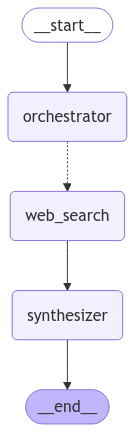

In [34]:
from langgraph.constants import Send, START, END
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage
from typing_extensions import TypedDict


# Assume that 'planner' is an LLM interface for generating queries
# Assume that 'llm' is an LLM interface for summarizing text
# Assume that 'tavily' is a tool interface for executing search queries


class WorkerState(TypedDict):
    query: SearchQuery  # The search query for this worker
    completed_results: Annotated[
        list, operator.add
    ]  # Shared list for aggregating results


# Node: Orchestrator
def orchestrator(state: State) -> dict:
    """
    Generate a set of search queries based on the difficult question

    - Use the planner LLM to generate queries
    - Return the generated queries list under key 'queries'
    """
    generated = planner.invoke(
        [
            SystemMessage(
                content="Generate a list of search queries that are required to answer the difficult question"
            ),
            HumanMessage(content=f"Here is the question: {state['question']}"),
        ]
    )
    # Assume that the planner returns an object with an attribute 'queries' that is a list of Query
    return {"queries": generated.queries}


# Node: Worker using the tavily tool
def web_search(state: WorkerState) -> dict:
    """
    Execute a search for the provided query using the tavily tool

    - Extract the query text from the state
    - Invoke the tavily search tool with the query
    - Return the search result as part of completed_results
    """
    query_text = state["query"].query  # Use attribute access instead of subscripting
    search_result = tavily_tool.invoke(query_text)
    return {"completed_results": search_result}


# Node: Synthesizer
def synthesizer(state: State) -> dict:
    """
    Synthesize the final answer from aggregated search results

    - Combine the search results into a single context string
    - Use the llm to summarize the search results and answer the question
    - Return the final answer
    """
    aggregated_results = "\n\n---\n\n".join(state["completed_results"])
    summary = llm.invoke(
        [
            SystemMessage(
                content="Summarize the following search results to answer the difficult question"
            ),
            HumanMessage(
                content=f"Search results:\n{aggregated_results}\n\nQuestion: {state['question']}"
            ),
        ]
    )
    return {"final_answer": summary.content}


# Conditional edge: Assign a web_search worker for each generated query
def assign_workers(state: State) -> List[Send]:
    """
    Assign a web_search worker for each query in the generated plan

    - Iterate over each query in state['queries']
    - For each query, send a task to the web_search worker
    """
    return [Send("web_search", {"query": q}) for q in state["queries"]]


# Build the workflow
workflow_builder = StateGraph(State)

# Add nodes to the workflow
workflow_builder.add_node("orchestrator", orchestrator)
workflow_builder.add_node("web_search", web_search)
workflow_builder.add_node("synthesizer", synthesizer)

# Connect nodes with edges
workflow_builder.add_edge(START, "orchestrator")
workflow_builder.add_conditional_edges("orchestrator", assign_workers, ["web_search"])
workflow_builder.add_edge("web_search", "synthesizer")
workflow_builder.add_edge("synthesizer", END)

# Compile the workflow
workflow = workflow_builder.compile()

# Optionally, display the workflow graph (if running in a Jupyter environment)
from IPython.display import Image

display(Image(workflow.get_graph().draw_mermaid_png()))

In [35]:
from pprint import pprint
# Invoke the workflow with a difficult question
initial_state: State = {
    "question": "How does quantum computing impact cryptography in a post-quantum world",
    "queries": [],
    "completed_results": [],
    "final_answer": "",
}

final_state = workflow.astream(initial_state)
async for state in final_state:
    pprint(state)

# Render the final answer using Markdown
from IPython.display import Markdown

Markdown(final_state["final_answer"])

{'orchestrator': {'queries': [SearchQuery(query='impact of quantum computing on modern cryptography', justification="General exploration of how quantum computing affects cryptographic systems, which is the main focus of the user's question."),
                              SearchQuery(query='post-quantum cryptography methods', justification='Understanding the methods being developed to secure data against quantum computing threats.'),
                              SearchQuery(query='quantum computing threats to RSA and ECC', justification='Investigating specific cryptographic algorithms that are vulnerable to quantum computing.'),
                              SearchQuery(query='current status of quantum computers', justification='Assessing the current capabilities of quantum computers to understand the urgency of transitioning to post-quantum cryptography.'),
                              SearchQuery(query="Shor's algorithm impact on cryptography", justification="Shor's algorithm can 

TypeError: sequence item 0: expected str instance, dict found

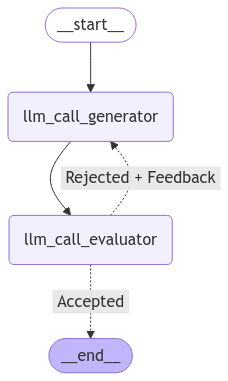

Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!


In [ ]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

In [ ]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

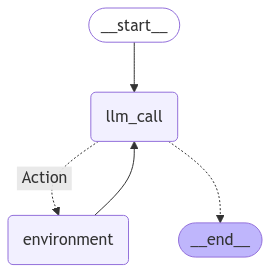

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_VMpTjBQRm8Ead2ivcELNYhYi)
 Call ID: call_VMpTjBQRm8Ead2ivcELNYhYi
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

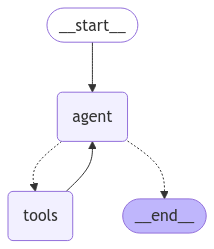

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_wU9ugtV1mDpaGggVNtJCDNza)
 Call ID: call_wU9ugtV1mDpaGggVNtJCDNza
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.


In [ ]:
from langgraph.prebuilt import create_react_agent

# Pass in:
# (1) the augmented LLM with tools
# (2) the tools list (which is used to create the tool node)
pre_built_agent = create_react_agent(llm, tools=tools)

# Show the agent
display(Image(pre_built_agent.get_graph().draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()